### Creating bathymetry for Lake Geneva 

In [17]:
import os
import glob

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

import json

In [7]:
with open('config.json', 'r') as file:
    current_project = json.load(file)["current_project"]

config_name = current_project['config_name']

In [8]:
with open('config.json', 'r') as file:
    config = json.load(file)["simulation_config"][config_name]

In [19]:
#path where to save file 
output_folder_path = config['grid_folder_path']

In [20]:
# loading swiss topo files first (resolution is 1km)
path_swisstopo = config['swiss_topo_path']
files_topo = glob.glob(os.path.join(path_swisstopo, '*.asc'))

In [21]:
# loading x and y files 
grid_folder_path = config['grid_folder_path']

with open(os.path.join(grid_folder_path, 'x_sg_grid.npy'), 'rb') as f:
    x = np.load(f)

with open(os.path.join(grid_folder_path, 'y_sg_grid.npy'), 'rb') as f:
    y = np.load(f)

In [22]:
def extract_topo(filename):
    
    # get out variables 
    ncols = None
    nrows = None
    xcorner = None
    ycorner  = None
    cellsize = None
    flag = None 
    
    # Read the file and extract ncols and nrows
    with open(filename, 'r') as file:
        
        for i in range(6):
            line = file.readline()
            
            if line.startswith('ncols'):
                ncols = int(line.split()[1])
            elif line.startswith('nrows'):
                nrows = int(line.split()[1])
            elif line.startswith('xllcorner'):
                xcorner = int(line.split()[1])
            elif line.startswith('yllcorner'):
                ycorner = int(line.split()[1])
            elif line.startswith('cellsize'):
                cellsize = int(line.split()[1])
            elif line.startswith('nodata_value'):
                flag = int(line.split()[1])
    
    # swiss coordinates for the whole section 
    xsc = np.arange(xcorner, (xcorner + (ncols*cellsize)), cellsize)
    ysc = np.arange(ycorner, (ycorner + (nrows*cellsize)), cellsize)

    
    # extract data (skipping first 6 rows)
    data_topo = np.loadtxt(filename, skiprows=6)
    data_topo = np.flip(data_topo, axis=0) #need to flip because somewhere along the way something is funky
    
    # Replace values of -999 with NaN
    data_topo[data_topo == flag] = np.nan
    
    # creating xarray 

    #swiss coordinates
    topo = xr.DataArray(
        data_topo,
        coords=[ysc, xsc],
        dims=['ysc', 'xsc'],)

    
    return (topo)        

Extract and concatenate files from Swiss topo

In [23]:
# loading swiss topo files first (resolution is 1km)
all_topo = []

for file in files_topo:
    topo = extract_topo(file)
    all_topo.append(topo)

all_topo = xr.combine_by_coords(all_topo)

In [24]:
#transform coordinates from ch1903+ to ch1903
all_topo['xsc'] = all_topo.xsc.values - 2000000
all_topo['ysc'] = all_topo.ysc.values - 1000000

In [25]:
# get max elevation 
all_topo.where(all_topo == all_topo.max(), drop=True)

<xarray.DataArray (ysc: 1, xsc: 1)> Size: 8B
array([[372.04916]])
Coordinates:
  * xsc      (xsc) int32 4B 527524
  * ysc      (ysc) int32 4B 150846

#### Interpolate grid

### grid values

In [26]:
x_topo, y_topo = np.meshgrid(all_topo.xsc.values,all_topo.ysc.values)
values_topo = all_topo.values.flatten()

topo_grid_interp = griddata((x_topo.flatten(), y_topo.flatten()), values_topo, (x.flatten(), y.flatten()), method='nearest')

In [81]:
xr_topo_grid_interp = xr.DataArray(
        topo_grid_interp.reshape(x.shape),
        coords= {'xsc': np.arange(x.shape[1]), 'ysc':np.arange(x.shape[0])},
        dims=['ysc', 'xsc'],)

In [82]:
mask = ~np.isnan(xr_topo_grid_interp)

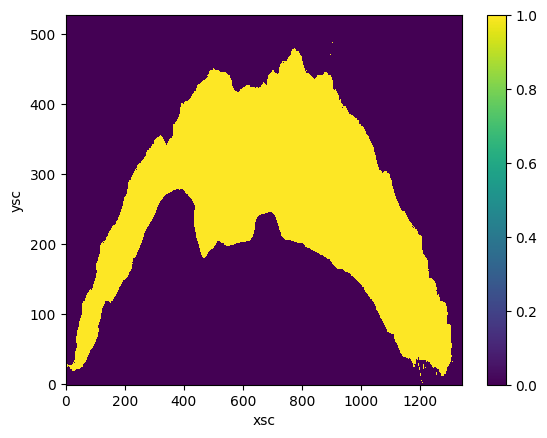

In [83]:
mask.plot()

In [84]:
xr_bathy_grid_interp = xr_topo_grid_interp - config['lake_altitude']

In [85]:
clean_bathy_grid_interp = xr_bathy_grid_interp.where(mask == True, 2)

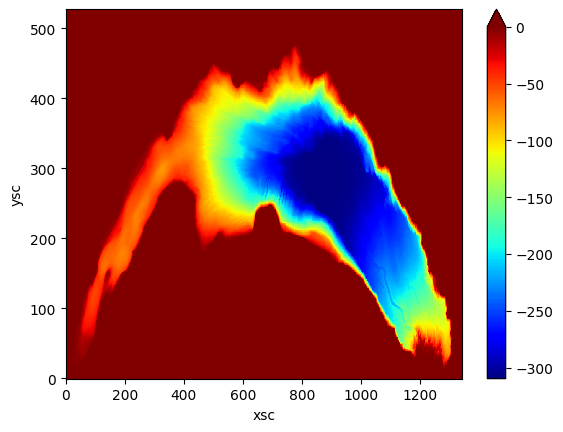

In [86]:
clean_bathy_grid_interp.plot(vmax=0, cmap='jet')

### Setting zeros to something positive (that is setting non-water to land)

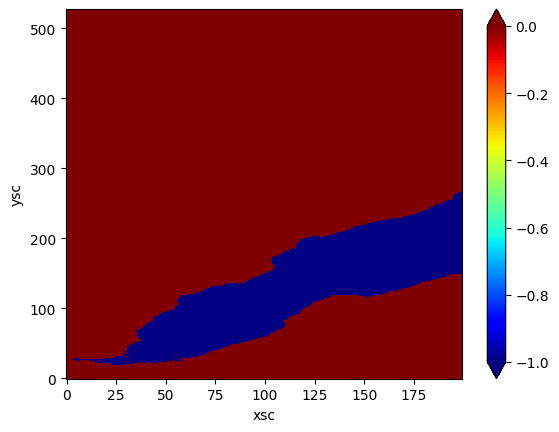

In [94]:
bathy_grid_filled = clean_bathy_grid_interp.where(clean_bathy_grid_interp <= -1 ,2)
bathy_grid_filled.sel(xsc = np.arange(200)).plot(vmin = -1, vmax=0, cmap='jet')

### Smooth out transitions in depth?
- not sure, need to check this out 

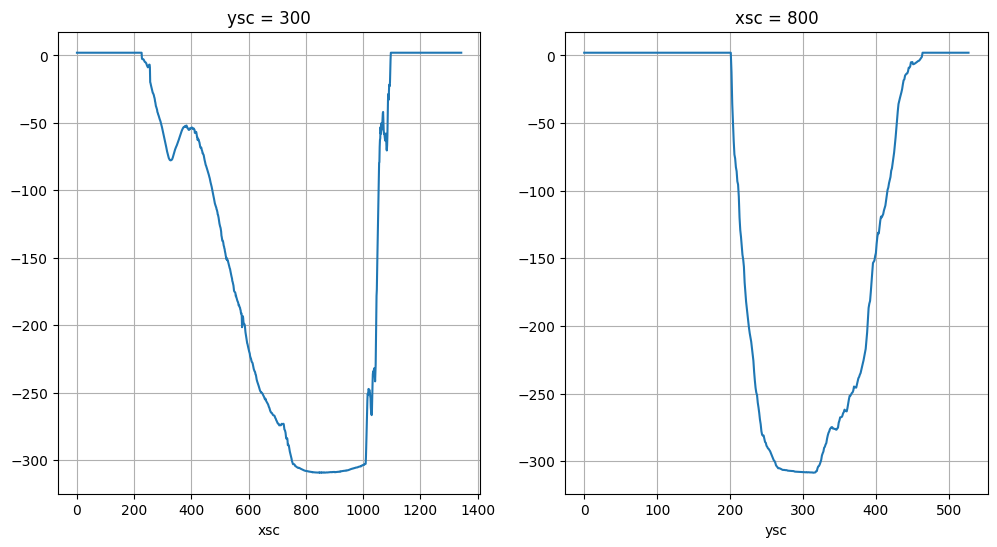

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

bathy_grid_filled.sel(ysc=300,method='nearest').plot(ax=ax1)
ax1.grid()

bathy_grid_filled.sel(xsc=800,method='nearest').plot(ax=ax2)
ax2.grid()

In [96]:
# saving bathy file 

def write_binary(path_fname: str,data: xr.DataArray, dtype: str):
    '''
    Saves data in the right binary format for MITgcm, in the dimension order XYT
    Output binary files have been read and tested 
    '''

    data = data.to_numpy() #convert to xarray to numpy first - and then save to binary
    data = data.astype(dtype)

    # Write to file
    fid = open(path_fname, 'wb')
    data.tofile(fid)
    fid.close()

    
#bathy_grid_filled = bathy_grid_filled.transpose('xsc','ysc')
write_binary(os.path.join(output_folder_path, f'bathy_{config_name}_big_endian.bin'),bathy_grid_filled, '>f8') # big-endian and precision 64
write_binary(os.path.join(output_folder_path, f'bathy_{config_name}_little_endian.bin'),bathy_grid_filled, '<f8') # little-endian and precision 64